# Реализация и сравнение алгоритмов

In [48]:
import pandas as pd
import numpy as np
import copy
import networkx as nx # для алгоритма дейкстры
import folium # для карты
import time

In [49]:
# Чтение файлов с данными

df_Nodes = pd.read_csv('Nodes.csv')
df_Nodes = df_Nodes.drop('Unnamed: 0', 1)

df_Ways_t = pd.read_csv('Ways_tags.csv')
df_Ways_t = df_Ways_t.drop('Unnamed: 0', 1)

df_Ways_n = pd.read_csv('Ways_nodes.csv')
df_Ways_n = df_Ways_n.drop('Unnamed: 0', 1)

df_Rels_t = pd.read_csv('Relations_tags.csv')
df_Rels_t = df_Rels_t.drop('Unnamed: 0', 1)

df_Rels_m = pd.read_csv('Relations_members.csv')
df_Rels_m = df_Rels_m.drop('Unnamed: 0', 1)

In [50]:
# Чтение матрицы расстояний всех точек (6 минут)

start_time = time.time()

nodes = df_Nodes.id.unique()

matrix = pd.read_csv('Adj_Matrix.csv')
matrix = matrix.drop('Unnamed: 0', 1)

matrix = matrix.set_axis(nodes, axis=0, inplace=False)
matrix = matrix.set_axis(nodes, axis=1, inplace=False)

print("%s seconds" % (time.time() - start_time))

329.4246370792389 seconds


In [54]:
# Чтение sights

sights = open('Sights.txt').readline().split()
sights = [int(sight) for sight in sights]

In [55]:
# Добавим начальную и конечную точки 

start = 2912492831
end = 2798201435

sights.append(start)
sights.append(end)

In [56]:
# Словарь для удобного обращения

sights_indexes = dict(enumerate(sights))

### Алгоритм Дейкстры
Необходим для построения матрицы смежности достопримечательностей для алгоритмов решения задачи коммивояжера.  
Матрица смежностей для поиска кратчайших путей алгоритмом Дейкстры создается отдельно в файле DataFrame_OSM.

In [58]:
start_time = time.time()

# Создаем граф
G = nx.Graph()

# Создаем точки как объекты Node (узлы)
for i in nodes:
    G.add_node(i)

# Соединяем смежные узлы в графе
for i in range(len(nodes)):
    node1 = nodes[i]
    for j in range(len(nodes)):
        node2 = nodes[j]
        weight = matrix.at[node1, node2]
        if weight != 0:
            G.add_edge(node1, node2, weight=weight)

print("%s seconds" % (time.time() - start_time))

2915.16694188118 seconds


Строим матрицу для использования алгоритмов решения задачи коммивояжера.

In [59]:
# Функция для построения матрицы

def adj_matrix(sights):
    
    adj_matrix_sight = []

    for start in sights:
        adj_row = []
        for end in sights:
            # Заполнение главной диагонали матрицы бесконечностями (так как не должно быть узлов)
            if start == end:
                adj_row.append(float('inf'))
            else:
                try:
                    adj_row.append(nx.nx.shortest_path_length(G, start, end, weight='weight'))
                except:
                    adj_row.append(float('inf'))

        adj_matrix_sight.append(adj_row)
        
    return adj_matrix_sight

In [60]:
# Строим матрицу

adj_matrix_sight = adj_matrix(sights)

In [61]:
# Уберем ни с чем не связанные места

excepts = []
for i in range(len(adj_matrix_sight)):
    if adj_matrix_sight[i].count(float('inf')) > len(sights)-3:
        excepts.append(i)
        
exc = [sights_indexes[i] for i in excepts]
new_sights = sights[0:len(sights)-2]
new_sights = list(set(new_sights) - set(exc))

In [62]:
# Добавляем обратно начальную и конечные точки

new_sights.append(sights[-2])
new_sights.append(sights[-1])

In [63]:
# Снова строим матрицу

adj_matrix_sight_new = adj_matrix(new_sights)

In [153]:
# Проверка

check = []
for i in range(len(adj_matrix_sight_new)):
    if adj_matrix_sight_new[i].count(float('inf')) >= 2:
        check.append(i)
        
if len(check) == 0:
    
    with open("Матрица.txt", "w") as file:
        print(*adj_matrix_sight_new, file=file)
    
    adj_matrix_sight = adj_matrix_sight_new
    sights = new_sights
    
    sights_indexes = dict(enumerate(sights))
    s_idx_reverse = {v:k for k, v in sights_indexes.items()}

else:
    print('No')

Если достопримечательностей нет, то алгоритм должен прокладывать просто кратчайший маршрут.  
Если достопримечательность одна, то маршрут через нее, с учетом ограниченного времени. Если время не позволяет, то снова прокладываем просто кратчайший маршрут.  
Найдем такой путь в координатах.

In [65]:
flatten = lambda ids: [item for sublist in ids for item in sublist]

In [66]:
# Путь (по координатам)

def final_path(result):

    # Соединяем маршруты между точками в единый
    final_route = []
    for i in range(len(result)-1):
        final_route.append(nx.shortest_path(
            G, sights_indexes[result[i]], sights_indexes[result[i+1]], weight='weight'))

    # Уплощаем и удаляем дублированные "точки стыка"
    for i in range(len(final_route)-1):
        if final_route[i] != []:
            del final_route[i][-1]
    final_route = flatten(final_route)

    # Ищем координаты по точкам
    path = []
    for i in final_route:
        path.append(tuple([df_Nodes.loc[df_Nodes['id'] == i].lat.values[0],
                           df_Nodes.loc[df_Nodes['id'] == i].lon.values[0]]))
    return path

In [67]:
# Длина пути (Total distance)

def tot_dist(result):
    dis = 0
    for i in range(len(result)-1):
        dis += adj_matrix_sight[result[i]][result[i + 1]]
    return dis

In [107]:
# Визуализация маршрута на карте

def mapping(path, name):
    
    lats = [path[i][0] for i in range(len(path))]
    lons = [path[i][1] for i in range(len(path))]
    lat = np.mean(lats)
    lon = np.mean(lons)
    
    mymap = folium.Map(location=[lat, lon], zoom_start=15,
                   tiles='https://{s}.basemaps.cartocdn.com/rastertiles/voyager_labels_under/{z}/{x}/{y}{r}.png',
                   max_zoom=19,
                   attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>')
    
    folium.PolyLine(path, color='cadetblue', weight=4, opacity=1).add_to(mymap)
    
    folium.Marker([path[0][0], path[0][1]],
              popup="<b>Start</b>", icon=folium.Icon(color='darkblue', icon='user', prefix='fa')).add_to(mymap)
    folium.Marker([path[-1][0], path[-1][1]],
              popup="<b>End</b>", icon=folium.Icon(color='green', icon='flag')).add_to(mymap)
    
    mymap.save(name + '.html')
    
    return mymap

In [69]:
time = 60 # ограничение в минутах
bound = 1.1 * time * 60

path = []
if len(sights) == 2:
    result = [0, 1]
    path = final_path(result)
elif len(sights) == 3:
    result = [1, 0, 2]
    if tot_dist(result) - bound > 60:
        path = final_path([1, 2])
    else:
        path = final_path(result)
    
if len(path) != 0:
    mapping(path, 'Алгоритм Дейкстры')

Далее выполнять программу не нужно.

### Алгоритм ближайшего соседа

In [327]:
def nearest_neigbour(matrix_data, start, end):

    matrix = copy.deepcopy(matrix_data)
    n = len(matrix)
    way = []
    way.append(start)

    for i in range(1, n):
        row = []
        for j in range(0, n):
            # Выбираем строчку начальной точки в матрице связей
            row.append(matrix[way[i-1]][j])
        # Индексы пунктов ближайших городов соседей (до которых минимальное расстояние)
        if i != n-1:
            row[end] = float('inf')
        way.append(row.index(min(row)))
        for j in range(0, i):
            # Помечаем, что просмотрели город
            matrix[way[i]][way[j]] = float('inf')
    return way

In [353]:
# Находим маршрут
start_time = time.time()

result_nn = nearest_neigbour(adj_matrix_sight, start=len(sights)-2, end=len(sights)-1)

# Запись финального пути по координатам

path_nn = final_path(result_nn)

print("%s seconds" % (time.time() - start_time))

0.6352307796478271 seconds


In [113]:
# Рисуем маршрут на карте

mapping(path_nn, 'Nearest_neighbour')

In [116]:
# Оценка

# Функция приспособленности

def Estim(result):

    # Ограниченность по времени
    extra_dist = tot_dist(result) - bound
    estimate1 = df_rang[extra_dist < df_rang['metres']].ests.values
    if len(estimate1) == 0:
        estimate1 = 0
    else:
        estimate1 = estimate1[0]
    
    
    # Количество достопримечательностей
    sights_number = len(result)-2
    estimate2 = (sights_number/len(sights))*10

    
    # Пересекающиеся маршруты
    
    # Соединяем маршруты между точками в единый
    final_route = []
    for i in range(len(result)-1):
        final_route.append(nx.shortest_path(
            G, sights_indexes[result[i]], sights_indexes[result[i+1]], weight='weight'))
    # Уплощаем и удаляем дублированные "точки стыка"
    for i in range(len(final_route)-1):
        if final_route[i] != []:
            del final_route[i][-1]
    final_route = flatten(final_route)
    # Смотрим дубликаты
    seen = []
    dublicates = 0
    for i in final_route:
        if i in seen:
            dublicates += 1
        else:
            seen.append(i)
    estimate3 = (1-dublicates/len(final_route))*10

    return (estimate1*0.9 + estimate2*0.8 + estimate3*0.7)/(0.9+0.8+0.7)

In [354]:
Estim(result_nn)

5.088269745649263

### Генетический алгоритм

In [73]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

import random
import array

import matplotlib.pyplot as plt
import seaborn as sns

/Users/elizaveta/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [356]:
# Убираем начальную и конечные точки

sights = sights[0:len(sights)-2]
time = 60
bound = 1.1 * time * 60

Скорость пешехода 1.1 м/с. 
Допустим, что можно опаздывать на 2 минуты. Ограничение: 132 метра

In [314]:
# Система оценки маршрута по затраченному времени

metres = [132, 132*2, 132*3, 132*4, 132*5, 132*6]
ests = [10, 8, 6, 4, 2, 0]
df_rang = pd.DataFrame()
df_rang['metres'] = metres
df_rang['ests'] = ests

In [276]:
# Функция приспособленности

def Restrict(individual):

    # Ограниченность по времени
    d = dict()
    for i in range(len(individual)):
        if individual[i] != 0:
            d[individual[i]] = i
    list_keys = sorted(list(d.keys()))
    
    result = [len(sights)] + [d[i] for i in list_keys] + [len(sights)+1]
    extra_dist = tot_dist(result) - bound
    estimate1 = df_rang[extra_dist < df_rang['metres']].ests.values
    if len(estimate1) == 0:
        estimate1 = 0
    else:
        estimate1 = estimate1[0]
    
    
    # Количество достопримечательностей
    sights_number = len(result)-2
    estimate2 = (sights_number/len(sights))*10

    
    # Пересекающиеся маршруты
    
    # Соединяем маршруты между точками в единый
    final_route = []
    for i in range(len(result)-1):
        final_route.append(nx.shortest_path(
            G, sights_indexes[result[i]], sights_indexes[result[i+1]], weight='weight'))
    # Уплощаем и удаляем дублированные "точки стыка"
    for i in range(len(final_route)-1):
        if final_route[i] != []:
            del final_route[i][-1]
    final_route = flatten(final_route)
    # Смотрим дубликаты
    seen = []
    dublicates = 0
    for i in final_route:
        if i in seen:
            dublicates += 1
        else:
            seen.append(i)
    estimate3 = (1-dublicates/len(final_route))*10

    return (estimate1, estimate2, estimate3)

In [277]:
# Функция для создания хромомосомы

def create_ind():
    result = np.random.randint(0, 2, len(sights)) 
    nonzero = np.nonzero(result)[0]
    shuffle_order = np.random.permutation(len(nonzero))
    for i in nonzero:
        result[i] = shuffle_order[0]
        shuffle_order = np.delete(shuffle_order, 0)
    return result

In [298]:
# Задаем константы и создаем функции для алгоритма

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

POPULATION_SIZE = 100

MAX_GENERATIONS = 20

# Количество индивидуумов с наилучшим значением приспособленности, которые храним
HALL_OF_FAME_SIZE = 1

P_CROSSOVER = 0.8  # probability for crossover
P_MUTATION = 0.2   # probability for mutating an individual

toolbox = base.Toolbox()

creator.create("FitnessCompound", base.Fitness, weights=(0.9, 0.8, 0.7))

creator.create("Individual", array.array, typecode='i', fitness=creator.FitnessCompound)

toolbox.register("randomOrder", create_ind)

toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.randomOrder)

toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

toolbox.register("evaluate", Restrict)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=1.0/len(sights))

/Users/elizaveta/Applications/anaconda3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessCompound' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/elizaveta/Applications/anaconda3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [358]:
# Genetic Algorithm flow:
start_time = time.time()

# create initial population (generation 0):
population = toolbox.populationCreator(n=POPULATION_SIZE)

# prepare the statistics object:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)

# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

# perform the Genetic Algorithm flow with hof feature added:
population, logbook = algorithms.eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                          ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg   
0  	100   	5.0797
1  	88    	6.28415
2  	81    	6.9358 
3  	86    	6.85683
4  	87    	6.88894
5  	82    	6.93235
6  	78    	6.96016
7  	88    	6.9754 
8  	81    	6.92068
9  	85    	7.03771
10 	82    	6.9725 
11 	79    	7.07036
12 	86    	7.03322
13 	82    	7.04812
14 	83    	7.11683
15 	87    	7.11445
16 	91    	7.17345
17 	85    	7.34537
18 	88    	7.38087
19 	83    	7.38387
20 	83    	7.52878


In [359]:
best = hof.items[0]

d = dict()
for i in range(len(best)):
    if best[i] != 0:
        d[best[i]] = i
list_keys = sorted(list(d.keys()))

result_gen = [d[i] for i in list_keys]
result_gen.append(len(sights)+1)
result_gen.insert(0,len(sights))

print("%s seconds" % (time.time() - start_time))

59.9184730052948 seconds


In [360]:
(best.fitness.values[0]*0.9 + best.fitness.values[1]*0.8 + best.fitness.values[2]*0.7)/(0.9+0.8+0.7)

7.916666666666665

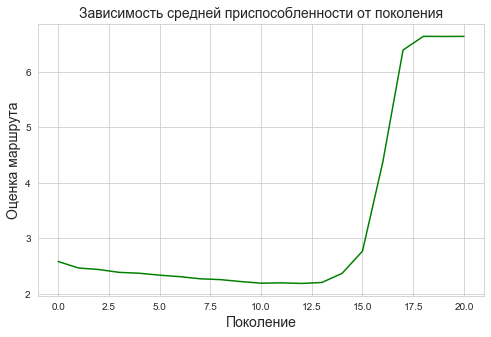

In [83]:
# plot statistics:
meanFitnessValues = logbook.select("avg")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Поколение', fontsize=14)
plt.ylabel('Оценка маршрута', fontsize=14)
plt.title('Зависимость средней приспособленности от поколения', fontsize=14)

# show plots:
plt.show()

In [283]:
path_gen = final_path(result_gen)

In [238]:
mapping(path_gen, 'Gen_Alg_new')

### Муравьиный алгоритм

In [179]:
class AntColony(object):
    
    def __init__(self, distances, n_ants, n_best, n_iterations, evaporation, alpha=1, beta=1):
        
        self.distances = distances  # матрица растояний
        self.pheromone = np.ones(self.distances.shape) / 10  # начальные данные о феромонах
        self.all_inds = range(len(distances))  # список городов
        self.n_ants = n_ants  # колличество муравьев
        self.n_best = n_best  # колличество элитных муравьев
        self.n_iterations = n_iterations  # колличество итераций
        self.evaporation = evaporation  # испарения феромона
        self.alpha = alpha
        self.beta = beta

    def run(self, start, end):
        best_path = None
        all_time_best_path = ("placeholder", 0) # на месте plaseholder должен быть маршрут, а inf - его длина
        average_values = []
        for i in range(self.n_iterations): # для каждой итерации
            all_paths = self.gen_all_paths(start, end) # генерируем маршруты для всех муравьев
            self.spread_pheronome(all_paths, self.n_best) # обновляем значения в матрице феромонов (учитывая расстояния пройденных муравьями маршрутов)
            best_path = max(all_paths, key=lambda x: x[1]) # выбираем кратчайший маршрут
            if best_path[1] > all_time_best_path[1]:
                all_time_best_path = best_path
            average_values.append(all_time_best_path[1])
            self.pheromone * self.evaporation # испаряем феромоны
        return (all_time_best_path, average_values)

    def spread_pheronome(self, all_paths, n_best):
        sorted_paths = sorted(all_paths, reverse=True, 
                              key=lambda x: x[1]) # сортируем маршруты по убыванию функции оценки
        for path, est in sorted_paths[:n_best]: # берем в отсортированном списке первых (5) лучших маршрутов (элитные муравьи)
            for i in range(len(path) - 1): # обновляем значения в матрице феромонов
                self.pheromone[(path[i], path[i+1])] += 1.0 / (11-est)

    # Функция оценки маршрута (оценка по 10балльной шкале)
    def reward(self, path):
    
        result = path
    
        # Ограниченность по времени
        extra_dist = tot_dist(result) - bound
        estimate1 = df_rang[extra_dist < df_rang['metres']].ests.values
        if len(estimate1) == 0:
            estimate1 = 0
        else:
            estimate1 = estimate1[0]

        # Количество достопримечательностей
        sights_number = len(result)-2
        estimate2 = (sights_number/len(sights))*10

        # Пересекающиеся маршруты
        # Соединяем маршруты между точками в единый
        final_route = []
        for i in range(len(result)-1):
            final_route.append(nx.shortest_path(
                G, sights_indexes[result[i]], sights_indexes[result[i+1]], weight='weight'))
        # Уплощаем и удаляем дублированные "точки стыка"
        for i in range(len(final_route)-1):
            if final_route[i] != []:
                del final_route[i][-1]
        final_route = flatten(final_route)
        # Смотрим дубликаты
        seen = []
        dublicates = 0
        for i in final_route:
            if i in seen:
                dublicates += 1
            else:
                seen.append(i)
        estimate3 = (1-dublicates/len(final_route))*10
    
        return (estimate1*0.9+estimate2*0.8+estimate3*0.7)/(0.9+0.8+0.7)
    
    def gen_all_paths(self, start, end):
        all_paths = []
        for i in range(self.n_ants): # для каждого муравья
            path = self.gen_path(start, end) # создаем маршрут
            all_paths.append((path, self.reward(path))) # добавляем маршрут и его оценку
        return all_paths

    def gen_path(self, start, end):
        path = [start]
        visited = set()
        visited.add(start) # посещенные города
        visited.add(end)
        prev = start
        for i in range(len(self.distances) - 2):
            move = self.pick_move(
                self.pheromone[prev], self.distances[prev], visited)
            visited.add(move) # добавляем в посещенные
            random = np.random.randint(2) # но добавим фичу, что не посещаем этот город вовсе
            if random == 1:
                path.append(move) # добавляем в маршрут
                prev = move
        path.append(end)  # конечная точка
        return path

    def pick_move(self, pheromone, dist, visited):
        pheromone = np.copy(pheromone) # это копия строки из матрицы феромонов, соответствующая одному городу
        pheromone[list(visited)] = 0 # в текущей копии зануляем то, что уже посещено
        row = pheromone ** self.alpha * ((1.0 / dist) ** self.beta)
        norm_row = row / row.sum() # вероятности перехода
        move = np.random.choice(self.all_inds, 1, p=norm_row)[0] # следующий шаг (рандомный)
        return move

In [361]:
start_time = time.time()

distance = np.array(adj_matrix_sight)
ant_colony = AntColony(distance, 15, 5, 50, 0.5, alpha=1, beta=3)
shortest_path = ant_colony.run(len(distance)-2, len(distance)-1)

print("%s seconds" % (time.time() - start_time))

29.379558086395264 seconds


In [362]:
print("Оценка маршрута: ", shortest_path[0][1])

Оценка маршрута:  8.644308943089431


In [288]:
result_ant = shortest_path[0][0]

In [248]:
tot_dist(result_ant)

4083

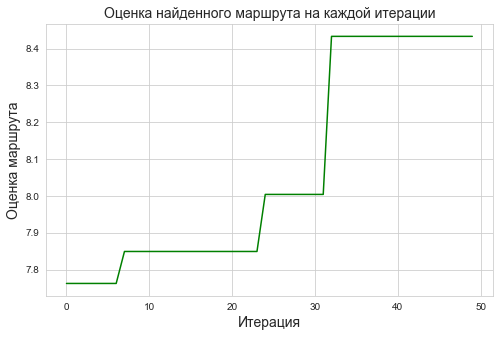

In [187]:
# plot statistics:
meanFitnessValues = shortest_path[1]
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Итерация', fontsize = 14)
plt.ylabel('Оценка маршрута', fontsize = 14)
plt.title('Оценка найденного маршрута на каждой итерации', fontsize = 14)

# show plots:
plt.show()

In [184]:
path_ant = final_path(result_ant)

In [185]:
mapping(path_ant, 'Ant_Alg_new')

Добавление кратчайшего

In [240]:
final_route = nx.shortest_path(
    G, start, end, weight='weight')

path = []
for i in final_route:
    path.append(tuple([df_Nodes.loc[df_Nodes['id'] == i].lat.values[0],
                       df_Nodes.loc[df_Nodes['id'] == i].lon.values[0]]))

lats = [path_ant[i][0] for i in range(len(path_ant))]
lons = [path_ant[i][1] for i in range(len(path_ant))]
lat = np.mean(lats)
lon = np.mean(lons)

mymap = folium.Map(location=[lat, lon], zoom_start=15,
                   tiles='https://{s}.basemaps.cartocdn.com/rastertiles/voyager_labels_under/{z}/{x}/{y}{r}.png',
                   max_zoom=19,
                   attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>')

folium.PolyLine(path_ant, color='cadetblue', weight=4, opacity=1).add_to(mymap)
folium.PolyLine(path, color='red', weight=4, opacity=1).add_to(mymap)

folium.Marker([path[0][0], path[0][1]],
              popup="<b>Start</b>", icon=folium.Icon(color='darkblue', icon='user', prefix='fa')).add_to(mymap)
folium.Marker([path[-1][0], path[-1][1]],
              popup="<b>End</b>", icon=folium.Icon(color='green', icon='flag')).add_to(mymap)

In [241]:
folium.Marker([59.934831, 30.325077],
              popup="<b>Казанский Собор</b>", icon=folium.Icon(color='blue', icon='star', prefix='fa')).add_to(mymap)

folium.Marker([59.938478, 30.332201],
              popup="<b>Русский музей</b>", icon=folium.Icon(color='blue', icon='star', prefix='fa')).add_to(mymap)

folium.Marker([59.937311, 30.331643],
              popup="<b>Памятник А.С. Пушкин</b>", icon=folium.Icon(color='blue', icon='star', prefix='fa')).add_to(mymap)

folium.Marker([59.933341, 30.343941],
              popup="<b>Конь Клодта</b>", icon=folium.Icon(color='blue', icon='star', prefix='fa')).add_to(mymap)

folium.Marker([59.9376, 30.3296],
              popup="<b>Музей-квартира И.И. Бродского</b>", icon=folium.Icon(color='blue', icon='star', prefix='fa')).add_to(mymap)

folium.Marker([59.936606, 30.345262],
              popup="<b>Шереметевский дворец</b>", icon=folium.Icon(color='blue', icon='star', prefix='fa')).add_to(mymap)

folium.Marker([59.939672, 30.323701],
              popup="<b>Особняк Слепцова</b>", icon=folium.Icon(color='blue', icon='star', prefix='fa')).add_to(mymap)

folium.Marker([59.941186, 30.320874],
              popup="<b>Музей-квартира А.С. Пушкина</b>", icon=folium.Icon(color='blue', icon='star', prefix='fa')).add_to(mymap)


In [243]:
mymap.save('ant+dijkstra' + '.html')
mymap